 <div style='text-align:center;'><img src='./bb.jpg' alt='NORAT'></div>

# Sentiment Analysis of Borat's mocumentary reviews
**Author:** Assel Kassenova <br>
**Sources:** Rotten Tomatoes | imdb <br>
**Date:** 11th November 2023 <br>

**Project Context:** As a kazkahstany, i wanted to quantify viewer opinion on Borat mockumentary. 


**Project Problem.** Task is to *build models which can identify the sentiment (positive or negative) of each of these non-rated interactions*.

**Analytical Context.** The data will be scraped from Imdb and Rotten Tomato web page , ans saved in CSV format. I will combine some text processing procedures and develop classification model to develop algorithms capable of classifying interactions by sentiment

In this pet project i will be doing the following:
1. Data sourcing and ingestion. Saving in CSV format.
2. Create database, concat 2 datasets and normalize rating in MySQL (i will provide some screen shots of manipulations) 
3. Perform basic pre-processing to prepare the data for modeling.
4. Build machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).
5. Visualize data. Bigrams, Trigrams and final sentiment proportion.

# Data sourcing and ingestion 
scraping reviews from IMDb 

In [6]:
import pandas as pd
import numpy as np
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.by import By
from parsel import Selector
from tqdm import tqdm

# intitializing web driver chrome 
driver = webdriver.Chrome()  

url = 'https://www.imdb.com/title/tt0443453/reviews'
driver.get(url)
sleep(30)  

# scrolling to load the reviews 
while True:
    try:
        load_more_button = driver.find_element(By.ID, 'load-more-trigger')
        load_more_button.click()
        sleep(4)  # wait 4 sec to load web page 
    except Exception:
        break

# extract reviews ,rating, author name, review title and review 
rating_list = []
review_date_list = []
review_title_list = []
author_list = []
review_list = []
review_url_list = []

reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')
for d in tqdm(reviews):
    sel2 = Selector(text=d.get_attribute('innerHTML'))
    
    rating = sel2.css('.rating-other-user-rating span::text').extract_first(default=np.NaN)
    review = sel2.css('.text.show-more__control::text').extract_first(default=np.NaN)
    review_date = sel2.css('.review-date::text').extract_first(default=np.NaN)
    author = sel2.css('.display-name-link a::text').extract_first(default=np.NaN)
    review_title = sel2.css('a.title::text').extract_first(default=np.NaN)
    
    
    rating_list.append(rating)
    review_date_list.append(review_date)
    review_title_list.append(review_title)
    author_list.append(author)
    review_list.append(review)

driver.quit()

# creating dataframe 
borat_reviews_ratings = pd.DataFrame({
    'Review_Date': review_date_list,
    'Author': author_list,
    'Rating': rating_list,
    'Review_Title': review_title_list,
    'Review': review_list,
})

# saving data in csv 
borat_reviews_ratings.to_csv("borat_reviews_rating.csv")

100%|███████████████████████████████████████| 1361/1361 [00:20<00:00, 65.35it/s]


In [8]:
Imdb = pd.read_csv("borat_reviews_rating.csv")

Displying scraped dataframe from Imdb. 1361 rows and 5 variables.

In [10]:
Imdb.head()

Unnamed: 0        Review_Date           Author  Rating  \
0           0   13 November 2006     evanston_dad     8.0   
1           1  29 September 2020        danielrko     9.0   
2           2   23 February 2007  MichaelMargetis     NaN   
3           3    1 November 2007           kjaney    10.0   
4           4       18 June 2007      rorosuperro    10.0   

                                        Review_Title  \
0   A Hilarious (and Much Needed) Assault on Dece...   
1       7.3 ? Where is your sense of humor people?\n   
2   "He insist we not fly in case the Jews repeat...   
3           One of the best films I have ever seen\n   
4                    Borat: A laugh out loud movie\n   

                                              Review  
0  Sacha Baron Cohen comes to America in the guis...  
1  Wonderfull movie.\nYou laugh until you cry.\nA...  
2  Many people have practically no idea who Sacha...  
3  In terms of pure unadulterated cringe-worthine...  
4  Before I go on and recommend EVERYONE to see t...

scraping reviews from Rotten Tomattoes 

In [7]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException

# function to scrape review information from the current page
def Scrape(dataframe):
    reviews = driver.find_elements(By.CLASS_NAME, 'audience-review-row')  # finding all reviews from the page 

    # extract data from each review and add to the dataframe
    data = []
    for r in reviews:
        name = r.find_element(By.CLASS_NAME, 'audience-reviews__name-wrap').text
        date = r.find_element(By.CLASS_NAME, 'audience-reviews__duration').text
        score = r.find_element(By.CLASS_NAME, 'audience-reviews__score')
        stars = score.find_elements(By.TAG_NAME, 'span.star-display__filled')
        rating = len(stars)
        review = r.find_element(By.CLASS_NAME, 'audience-reviews__review').text

        data.append({'Name': name, 'Date': date, 'Rating': rating, 'Review': review})

    return pd.concat([dataframe, pd.DataFrame(data)], ignore_index=True)


reviewData = pd.DataFrame(columns=['Name', 'Date', 'Rating', 'Review'])

driver = webdriver.Safari()


driver.get('https://www.rottentomatoes.com/m/borat_subsequent_moviefilm/reviews?type=user')

while True:
    reviewData = Scrape(reviewData)

    try:
        # wait for the "Next" button to be clickable
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'rt-button[data-qa="next-btn"]'))
        )
        # click the "Next" button
        next_button.click()

       
        time.sleep(5)  # adjust the sleep duration as needed
    except (TimeoutException, NoSuchElementException):
        # if there is no "Next" button, save the data to a CSV file and quit the driver
        reviewData.to_csv('borat_review_rt.csv', index=False)
        driver.quit()
        break

In [2]:
import pandas as pd
rt = pd.read_csv("borat_review_rt.csv")

Displaying scraped dataframe from rotten tomato. 780 rows with 4 

In [3]:
rt.head()

Name          Date  Rating  \
0  \n                    \n                      ...  Oct 20, 2023       0   
1  \n                    \n                      ...   Oct 2, 2023       0   
2  \n                    \n                      ...  Aug 28, 2023       0   
3  \n                    \n                      ...  Jul 13, 2023       0   
4  \n                    \n                      ...   Jul 8, 2023       0   

                                              Review  
0  \n                        this is the funniest...  
1  \n                        This movies, has cha...  
2  \n                        LOL, the funniest 01...  
3  \n                        I find it disgusting...  
4  \n                        Took 3 hours to watc...

In [23]:
import numpy as np
import pandas as pd
import certifi
import re
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import PorterStemmer, LancasterStemmer # common stemmers
from nltk.stem import WordNetLemmatizer # common Lematizer
from nltk.corpus import wordnet

nltk.download('wordnet')

from pymystem3 import Mystem
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import ssl
nltk.download('punkt')

from collections import Counter

nltk.download('punkt')

# Set SSL certificate options for NLTK
ssl._create_default_https_context = ssl._create_unverified_context
nltk.data.path.append(certifi.where())

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


#### importing labaled dataset from IMDb 

The dataset with scraped reviews from IMDb and Rotten Tomatoes has only  2001 observations in total. Since 2001 observations too small to perform classifier, I've chosen to train the classifier using a labeled dataset specifically sourced from IMDb, consisting of 50,000 observations.

In [5]:
df=pd.read_csv('IMDB Dataset.csv')
df

review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [7]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
df = df.dropna()
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

#### Pre-processing to prepare the data for modeling 

In [6]:
# selecting non alpha numeric charactes that are not spaces
spl_chars = df['review'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

# getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

# unique special characters
set(flat_list)

{'\x08',
 '\t',
 '\x10',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '\x80',
 '\x84',
 '\x85',
 '\x8d',
 '\x8e',
 '\x91',
 '\x95',
 '\x96',
 '\x97',
 '\x9a',
 '\x9e',
 '\xa0',
 '¡',
 '¢',
 '£',
 '¤',
 '¦',
 '§',
 '¨',
 '©',
 '«',
 '\xad',
 '®',
 '°',
 '´',
 '·',
 '»',
 '¿',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '″',
 '₤',
 '▼',
 '★',
 '、',
 '\uf0b7',
 '，'}

Let's decomose the regular expression `[^A-Za-z0-9 ]+`:
- `[ ]`: match any character inside the list defined by the square brackets, including the space character `' '`
- `^`: start of the line
- `A-Z`: accept english upper case characters from A to Z
- `a-z`: accept english lower case characters from a to z
- `0-9`: accept single number characters from 0 to 9

Also, stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them.

In [11]:
# removing stop words 
stopwords = set(nltk_stopwords.words('english'))
np.array(stopwords)

array({"haven't", 'further', 'most', 'above', 'y', 'his', 'the', 'once', "she's", 'mightn', 'about', 'itself', 'against', 'had', 'your', 'have', 'yours', 'was', 'more', 'same', 'shan', "wasn't", 'we', 'hers', 'm', "shouldn't", "you're", 'they', 'no', 'after', 'those', "weren't", 'but', 'should', 'at', 'by', 'down', 'doesn', 'where', 'weren', 'or', 'a', 'its', 'each', 'few', 'can', "don't", 'ours', 'own', 'not', 'on', "you've", 'from', 'nor', 'himself', 'o', 'i', 'than', 're', "needn't", "wouldn't", 'very', "won't", 'will', 'wouldn', 'theirs', 'yourself', 'ma', 'you', 'too', 'has', 'won', 'over', 'doing', 'yourselves', 'if', 'there', 'off', 'themselves', 'that', "couldn't", 'now', 'he', 'such', 'because', 'couldn', 'why', 'what', 'don', 've', 'as', "hasn't", 'll', 't', 'so', 'our', 'below', 'during', 'be', 'ourselves', "you'd", 's', 'all', 'does', 'other', 'haven', 'under', 'then', "shan't", 'were', 'ain', 'hasn', 'and', 'shouldn', 'how', 'her', "mustn't", 'for', 'hadn', 'who', 'between

In [10]:
# cleaning text so i have only clean text 
def clear_text(review):
    clear_text = re.sub(r'[^A-Za-z0-9 ]+', '', review).lower()
    return " ".join(clear_text.split())



# function to remove stop words 
def clean_stop_words(review, stopwords):
    text = [word for word in review.split() if word not in stopwords]
    return " ".join(text)  # Join the list of words


Comparing random review of original text and cleaned text 

In [13]:
text = df['review'][np.random.randint(df.shape[0])]
print(text)
print('=======================================')
print(clean_stop_words((clear_text(text)), stopwords))

Hollywood's attempt to turn Jack London's life into a "Jack London" adventure film isn't a bad idea; certainly, he led an interesting, and sometimes adventurous, life. This film, however, winds up flat and unsatisfying. Most importantly, it lacks integrity. Michael O'Shea (as London) has some Londonesque speeches; and, it's nice to see his bearded Jack receive "The Call of the Wild" after spending some quality time alone, in the snowy mountains, with his dog, "Buck". Virginia Mayo and Susan Hayward are both very pretty. The film draws unfortunate "Yellow Peril" parallels between London's life and World War II, which are both strained and insulting. <br /><br />** Jack London (11/24/43) Alfred Santell ~ Michael O'Shea, Susan Hayward, Virginia Mayo
hollywoods attempt turn jack londons life jack london adventure film isnt bad idea certainly led interesting sometimes adventurous life film however winds flat unsatisfying importantly lacks integrity michael oshea london londonesque speeches 

In [16]:
start_clean = time.time()

df['text_clear'] = df['review']\
                                .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Text processing took: '+str(round(time.time() - start_clean, 2))+' sec')

Text processing took: 5.82 sec


In [17]:
df = df[['text_clear', 'sentiment']]
df

text_clear sentiment
0      one reviewers mentioned watching 1 oz episode ...  positive
1      wonderful little production br br filming tech...  positive
2      thought wonderful way spend time hot summer we...  positive
3      basically theres family little boy jake thinks...  negative
4      petter matteis love time money visually stunni...  positive
...                                                  ...       ...
49995  thought movie right good job wasnt creative or...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  catholic taught parochial elementary schools n...  negative
49998  im going disagree previous comment side maltin...  negative
49999  one expects star trek movies high art fans exp...  negative

[50000 rows x 2 columns]

In [18]:
sentiment_map = {'positive': 1, 'negative': 0}

# replacing column value to binary 
df['sentiment'].replace(sentiment_map, inplace=True)
df

/var/folders/lp/hdcvkrm129xd2hnyxjdc91280000gn/T/ipykernel_35854/1240714251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'].replace(sentiment_map, inplace=True)


text_clear  sentiment
0      one reviewers mentioned watching 1 oz episode ...          1
1      wonderful little production br br filming tech...          1
2      thought wonderful way spend time hot summer we...          1
3      basically theres family little boy jake thinks...          0
4      petter matteis love time money visually stunni...          1
...                                                  ...        ...
49995  thought movie right good job wasnt creative or...          1
49996  bad plot bad dialogue bad acting idiotic direc...          0
49997  catholic taught parochial elementary schools n...          0
49998  im going disagree previous comment side maltin...          0
49999  one expects star trek movies high art fans exp...          0

[50000 rows x 2 columns]

Displaying random 3 positive and 3 negative cleaned reviews 

In [19]:
for _ in range(3):
    
    sample_neg = df.query('sentiment == 0').sample(n = 1)
    
    sample_pos = df.query('sentiment == 1').sample(n = 1)
    
    print('sentiment: ', sample_pos.sentiment.values[0])
    
    print(sample_pos['text_clear'].values[0][:200]) 
    
    print('sentiment: ', sample_neg.sentiment.values[0])
    
    print(sample_neg['text_clear'].values[0][:200]) 
    
    print()

sentiment:  1
robert standishs novel triangular romantic situation ceylonese tea plantation events ceylon backgrounds pictorial beauty rewarding points william dieterles filmbr br story rich powerful planter peter 
sentiment:  0
would sort clich began bit title ill wait first movie made wonder kids stupid things like wander around labs break bottles realized movie message message beat kids things like wont happen things like 

sentiment:  1
ekocentric episode explores aftermath tragic events rocked castaways previous one main characters john locke sawyer kate hurley come terms incident hatch locke eko set find henry took turns eko missio
sentiment:  0
romantic comedy movies definitely fertile genre bellow average movies source frustration viewers one perfect example got place top ten worst moviesbr br history far creative jokes weak found reason si

sentiment:  1
disturbing film school killing sprees like one depicted actually happen truth carried teenagers like cal andrenormal kids no

Tokenizing the text_clear column , and preparing for lemmatization

In [22]:
df['text_clear_tokenized'] = df['text_clear'].apply(lambda x: word_tokenize(x))

df.head()

text_clear  sentiment  \
0  one reviewers mentioned watching 1 oz episode ...          1   
1  wonderful little production br br filming tech...          1   
2  thought wonderful way spend time hot summer we...          1   
3  basically theres family little boy jake thinks...          0   
4  petter matteis love time money visually stunni...          1   

                                text_clear_tokenized  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, br, br, filmin...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...

Now column text_clear_tokenized is ready for lemmatization.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

Fro example lemmatized version of word trouble, troubling, troubled will be trouble.

more deatiled infromation on lemmatization can be found here: 
https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.

In [24]:
lemmatizer = WordNetLemmatizer()

In [26]:
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]
    
df['reviews_text_lemm'] = df['text_clear_tokenized'].apply(lambda row: lemmatize_terms(row))

In [28]:
df = df[['text_clear', 'reviews_text_lemm', 'sentiment']]

### Obtaining TF-IDF vector representations of labeled texts

The process involves obtaining IDF (Inverse Document Frequency) values for words in the training dataset. IDF values are calculated as the logarithm of the ratio between the total number of documents and the number of documents containing a particular word. For instance, for common words that appear in almost every document, IDF would be close to one, whereas for specific words found in only one document out of a hundred, the IDF value would be higher, for example, 2 (assuming a base 10 logarithm).

Once we have a dictionary with IDF values, we can generate the vector representation of each text based on the following principle: multiply the IDF value of each word by its occurrence count (TF - Term Frequency) in the text.

In [29]:
train, test = train_test_split(df,
                        test_size = 0.2,
                        random_state = 12348,
                       )

print(train.shape)
print(test.shape)

(40000, 3)
(10000, 3)


In [30]:
# comparing distribution of 1 and 0 sentiment 
for sample in [train, test]:    
    print(sample[sample['sentiment'] == 1].shape[0] / sample.shape[0])

0.500625
0.4975


In [31]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))

tf_idf_positive = count_idf_positive.fit_transform(train.query('sentiment == 1')['text_clear'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('sentiment == 0')['text_clear'])

In [32]:
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)

In [33]:
positive_importance.query('word not in @negative_importance.word and idf < 10.8')

word        idf
61004  messageolympia  10.211640
61001    messageboard  10.211640
61000   messagebearer  10.211640
60999        messagea  10.211640
60996        mesquide  10.211640
...               ...        ...
73812           ponyo   7.813744
6050          antwone   7.813744
30839            emil   7.769292
30291         eightbr   7.726733
64784             nan   7.685911

[55514 rows x 2 columns]

In [34]:
negative_importance.query('word not in @positive_importance.word and idf < 10')

word       idf
85348         soils  9.803675
92411  thirteenyear  9.803675
84758          smbr  9.803675
84472      slinging  9.803675
61976         napir  9.803675
...             ...       ...
43534    hobgoblins  7.606450
35905    forwarding  7.436551
56146         manos  7.118097
12030          boll  6.598222
97855           uwe  6.571553

[7850 rows x 2 columns]

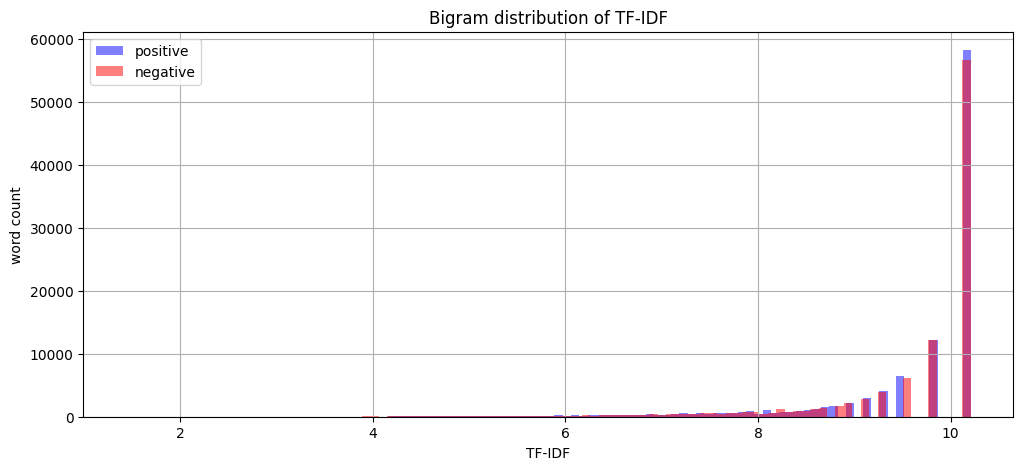

In [35]:
fig = plt.figure(figsize = (12,5))
positive_importance.idf.hist(bins = 100,
                             label = 'positive',
                             alpha = 0.5,
                             color = 'b',
                            )
negative_importance.idf.hist(bins = 100,
                             label = 'negative',
                             alpha = 0.5,
                             color = 'r',
                            )
plt.title('Bigram distribution of TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('word count')
plt.legend()
plt.show()

### Training model 

In [36]:
count_idf_1 = TfidfVectorizer(ngram_range=(1,1))

In [37]:
tf_idf_base_1 = count_idf_1.fit(df['text_clear'])
tf_idf_train_base_1 = count_idf_1.transform(train['text_clear'])
tf_idf_test_base_1 = count_idf_1.transform(test['text_clear'])

In [38]:
display(tf_idf_test_base_1.shape)
display(tf_idf_train_base_1.shape)

(10000, 180630)

(40000, 180630)

In [39]:
model_lr_base_1 = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [40]:
model_lr_base_1.fit(tf_idf_train_base_1, train['sentiment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [41]:
predict_lr_base_proba = model_lr_base_1.predict_proba(tf_idf_test_base_1)

#### Comparison of classifier quality on lemmatized text 

In [42]:
df['reviews_text_lemm_str'] = df['reviews_text_lemm'].apply(lambda x: ' '.join(x))

In [43]:
train['reviews_text_lemm_str'] = train['reviews_text_lemm'].apply(lambda x: ' '.join(x))
test['reviews_text_lemm_str'] = test['reviews_text_lemm'].apply(lambda x: ' '.join(x))

In [44]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tf_idf_lemm = tfidf_vectorizer.fit_transform(df['reviews_text_lemm_str'])

# Fit the vectorizer to the training data and transform both training and testing sets
tf_idf_train_lemm = tfidf_vectorizer.transform(train['reviews_text_lemm_str'])
tf_idf_test_lemm = tfidf_vectorizer.transform(test['reviews_text_lemm_str'])


In [45]:
display(tf_idf_train_lemm.shape)
display(tf_idf_test_lemm.shape)

(40000, 169438)

(10000, 169438)

In [46]:
model_lr_lemm = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [47]:
model_lr_lemm.fit(tf_idf_train_lemm, train['sentiment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [48]:
predict_lr_lemm_proba = model_lr_lemm.predict_proba(tf_idf_test_lemm)

In [49]:
def coin_classifier(X:np.array) -> np.array:
    predict = np.random.uniform(0.0, 1.0, X.shape[0])
    return predict

In [50]:
coin_predict = coin_classifier(tf_idf_test_base_1)

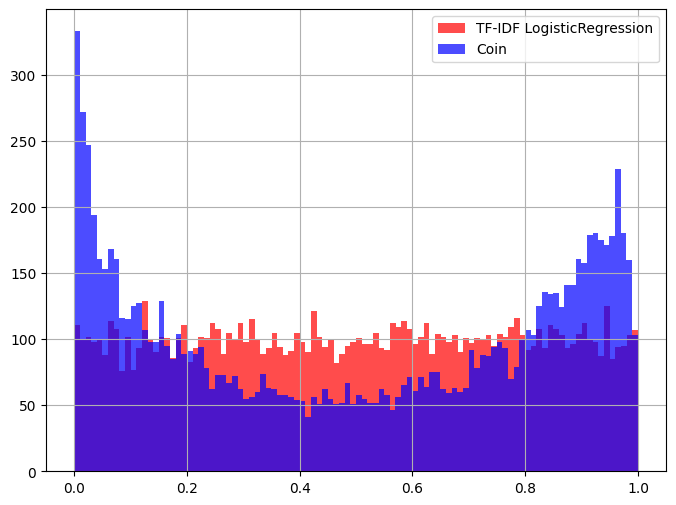

In [51]:
fif = plt.figure(figsize = (8, 6))

pd.Series(coin_predict)\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'r',
                      label = 'TF-IDF LogisticRegression'
                     )

pd.Series(predict_lr_base_proba[:, 1])\
                .hist(bins = 100,
                      alpha = 0.7,
                      color = 'b',
                      label = 'Coin'
                     )
plt.legend()   
plt.show()

Visualization of ROC curves

In [52]:
fpr_base, tpr_base, _ = roc_curve(test['sentiment'], predict_lr_base_proba[:, 1])
roc_auc_base = auc(fpr_base, tpr_base)

In [53]:
fpr_lemm, tpr_lemm, _ = roc_curve(test['sentiment'], predict_lr_lemm_proba[:, 1])
roc_auc_lemm = auc(fpr_lemm, tpr_lemm)

In [54]:
fpr_coin, tpr_coin, _ = roc_curve(test['sentiment'], coin_predict)
roc_auc_coin = auc(fpr_base, tpr_base)

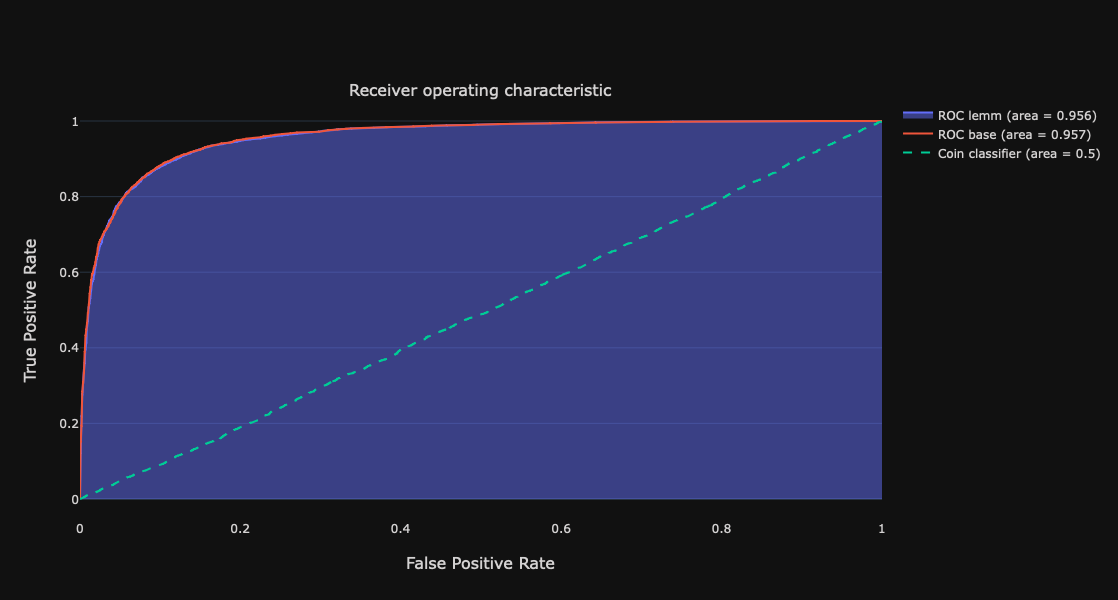

In [55]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

fig.add_trace(go.Scatter(
    x = fpr_lemm,
    y = tpr_lemm,
    fill = 'tozeroy',
    name = "ROC lemm (area = %0.3f)" % roc_auc_lemm,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    #fill = 'tozeroy',
    name = "ROC base (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier (area = 0.5)'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

#### lets see confusion matrix on 0.5 value 

In [56]:
# convusion matrix
confusion_matrix(test['sentiment'],
                 (predict_lr_base_proba[:, 1] > 0.5).astype('float'),
                 normalize='true',
                ) 

array([[0.87681592, 0.12318408],
       [0.09386935, 0.90613065]])

In [57]:
weights = pd.DataFrame({'words': count_idf_1.get_feature_names_out(),
                        'weights': model_lr_base_1.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

In [58]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

words    weights
177791    worst  11.052229
14690       bad   8.640900
173420    waste   8.207912
14090     awful   7.890337
21696    boring   7.013523
...         ...        ...
109020  neither   2.295385
137325    sadly   2.277292
50750    either   2.249003
54448   example   2.230472
89532      lack   2.219889

[100 rows x 2 columns]

In [59]:
weights_max = weights_max[:100]
weights_max

words   weights
68700           great  8.185243
54531       excellent  7.207569
18276            best  6.345290
177138      wonderful  5.585840
8633          amazing  5.579775
...               ...       ...
55644   extraordinary  1.953612
128794          quite  1.936809
110430           noir  1.920617
11171      appreciate  1.911372
155867   surprisingly  1.902140

[100 rows x 2 columns]

In [60]:
wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

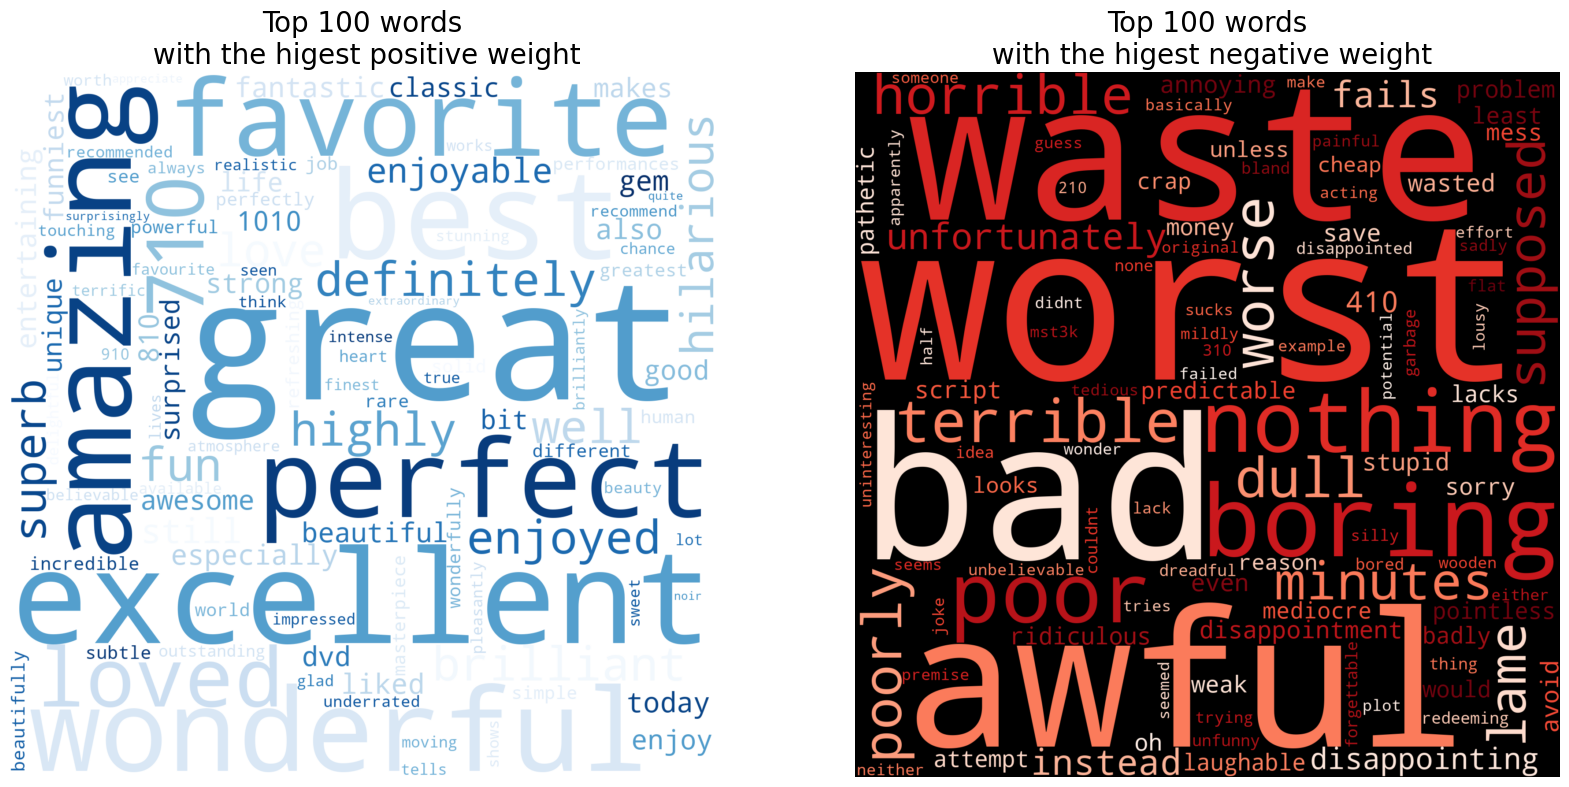

In [65]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Top ' +\
                str(weights_max.shape[0]) +\
                ' words\n with the higest positive weight',
               fontsize = 20
               )
ax[1].set_title('Top '  +\
                str(weights_min.shape[0]) +\
                ' words\n with the higest negative weight',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

In [66]:
vocab = weights.query('weights > 0.11 or weights < -0.11')['words']

In [67]:
vocab

25           010
88            10
89           100
91         10000
151         1010
           ...  
180533        zp
180547        zu
180552     zucco
180580      zulu
180587    zuniga
Name: words, Length: 8951, dtype: object

In [68]:
count_idf = TfidfVectorizer(vocabulary=vocab,
                            ngram_range=(1,1))

In [69]:
tf_idf = count_idf.fit_transform(df['text_clear'])

tf_idf_train = count_idf.transform(train['text_clear'])
tf_idf_test = count_idf.transform(test['text_clear'])

In [70]:
display(tf_idf_test.shape)
display(tf_idf_train.shape)

(10000, 8951)

(40000, 8951)

In [71]:
model_lr_base = LogisticRegression(solver = 'lbfgs',
                                    random_state = 12345,
                                    max_iter= 10000,
                                    n_jobs= -1)

In [72]:
model_lr_base.fit(tf_idf_train, train['sentiment'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [73]:
predict_lr_base_proba_1 = model_lr_base.predict_proba(tf_idf_test)

In [74]:
fpr_base_1, tpr_base_1, _ = roc_curve(test['sentiment'], predict_lr_base_proba_1[:, 1])
roc_auc_base_1 = auc(fpr_base_1, tpr_base_1)

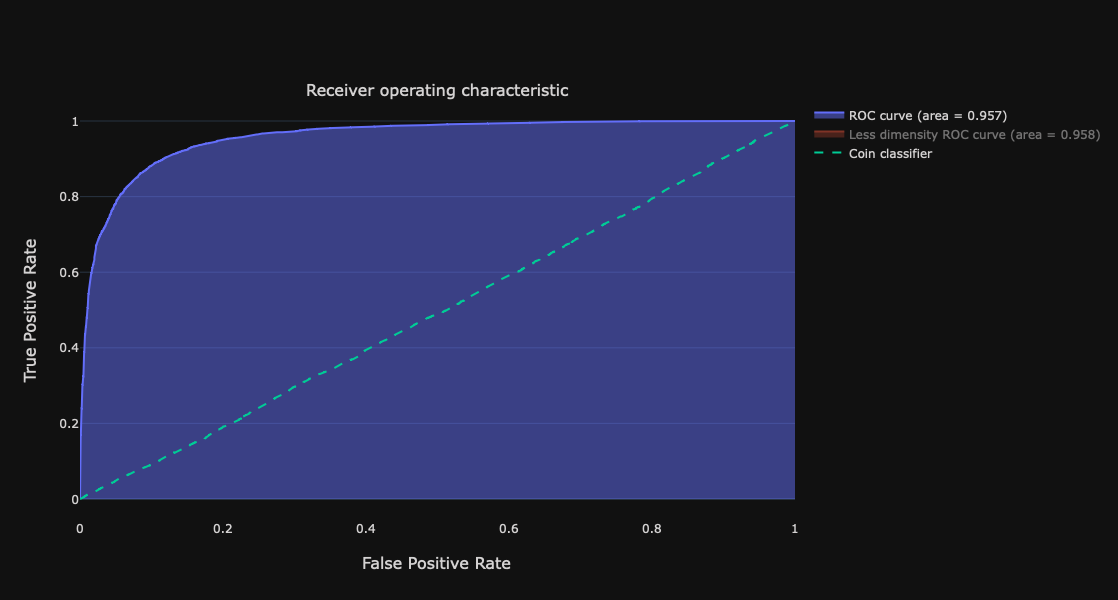

In [75]:
fig = make_subplots(1,1,
                    subplot_titles = ["Receiver operating characteristic"],
                    x_title="False Positive Rate",
                    y_title = "True Positive Rate"
                   )

fig.add_trace(go.Scatter(
    x = fpr_base,
    y = tpr_base,
    fill = 'tozeroy',
    name = "ROC curve (area = %0.3f)" % roc_auc_base,
    ))

fig.add_trace(go.Scatter(
    x = fpr_base_1,
    y = tpr_base_1,
    fill = 'tozeroy',
    name = "Less dimensity ROC curve (area = %0.3f)" % roc_auc_base_1,
    ))

fig.add_trace(go.Scatter(
    x = fpr_coin,
    y = tpr_coin,
    mode = 'lines',
    line = dict(dash = 'dash'),
    name = 'Coin classifier'
    ))


fig.update_layout(
    height = 600,
    width = 800,
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    template = 'plotly_dark',
    font_color = 'rgba(212, 210, 210, 1)'
    )

In [78]:
# Assuming 'corpus' is your list of text documents
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text_clear'])

# Get the shape of the TF-IDF matrix
num_documents, num_features = tfidf_matrix.shape
print("Number of documents:", num_documents)
print("Number of features (dimensionality):", num_features)


Number of documents: 50000
Number of features (dimensionality): 180630


An ROC curve measures the performance of a classification model across various threshold settings.
An area under the ROC curve (AUC-ROC) of 1.0 signifies a perfect classifier, while 0.5 suggests random guessing (no discrimination).
An AUC-ROC of 0.957 and 0.958 indicates a very good model performance in distinguishing between positive and negative sentiments, with 0.958 being slightly better in terms of the AUC value.
Therefore, reducing the dimensionality while maintaining a similar or slightly improved ROC curve area is generally a good outcome as it might indicate a more efficient model with a reduced number of features, simplifying computations without sacrificing performance.

### Selcetion optimal treshold 

In [79]:
scores = {}

weight = 0.55

for threshold in np.linspace(0, 1, 100):
    
    matrix = confusion_matrix(test['sentiment'],
                 (predict_lr_base_proba[:, 0] <  threshold).astype('float'),
                 normalize='true',
                )

    score = matrix[0,0] * weight + matrix[1,1] * (1 - weight)
    
    scores[threshold] = score

In [80]:
pd.DataFrame({'true_score':scores.values(),
             'threshold':scores.keys()},
             ).sort_values(by = 'true_score', ascending = False).head()

true_score  threshold
46    0.892236   0.464646
45    0.892002   0.454545
47    0.891923   0.474747
44    0.891372   0.444444
43    0.891176   0.434343

In [81]:
matrix = confusion_matrix(test['sentiment'],
                 (predict_lr_base_proba[:, 0] <  0.464646).astype('int'),
                 normalize='true',
                )
matrix

array([[0.89731343, 0.10268657],
       [0.11396985, 0.88603015]])

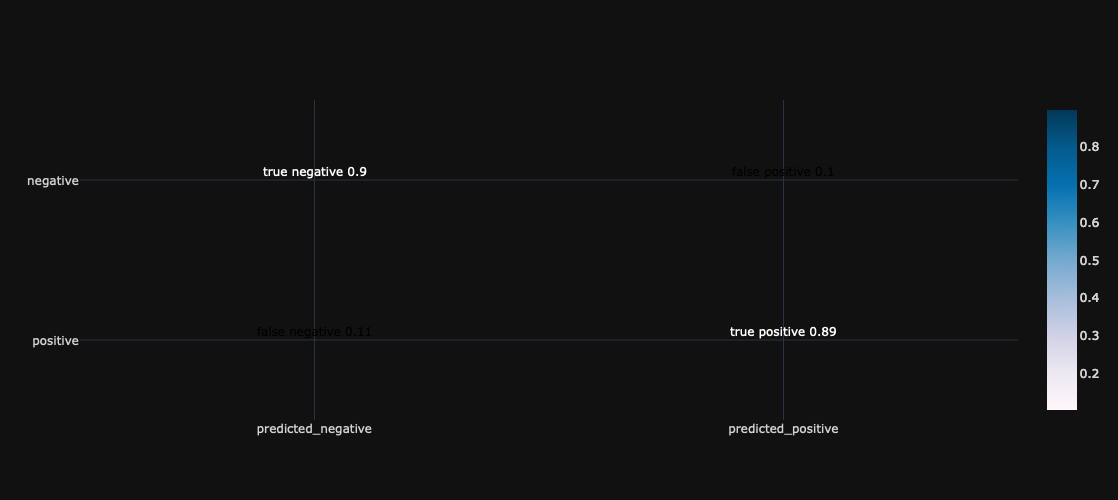

In [82]:

fig = make_subplots(1,1)

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix[1, :], matrix[0, :]],
     colorscale = 'PuBu'
))

fig.add_trace(go.Heatmap(
     y = [ 'positive', 'negative'],
     x = ['predicted_negative', 'predicted_positive'],
     z = [matrix[1, :], matrix[0, :]],
     colorscale = 'PuBu'
))

fig.add_annotation(x=0, y=0,
            text = "false negative " + str(round(matrix[1,0], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=1,
            text = "false positive " + str(round(matrix[0,1], 2)),
            showarrow=False,
            font = dict(color = 'black'),
            yshift=10)

fig.add_annotation(x=1, y=0,
            text = "true positive " + str(round(matrix[1,1], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)

fig.add_annotation(x=0, y=1,
            text = "true negative " + str(round(matrix[0,0], 2)),
            showarrow=False,
            font = dict(color = 'white'),
            yshift=10)


fig.update_layout(height = 500,
                  width = 500,
                  template = 'plotly_dark',
                  font_color = 'rgba(212, 210, 210, 1)',
                 ).show()

### Classifiyng Borat reviews 

Using the trained TF-IDF vectorizer and logistic regression, i will obtain probability scores for negativity and positivity in each of the review.

In [85]:
import pymysql
import pandas as pd

I extracted and processed data from IMDb and Rotten Tomattoes, resulting in two distinct DataFrames containing various attributes. To facilitate a comprehensive review analysis, I opted to construct a MySQL database named 'Review'

The database comprises the concat of DataFrame, consolidating pertinent information from both sources. It specifically focuses on the 'Review' and 'Rating' columns, excluding other variables. As IMDb ratings range from 1 to 10 and Rotten Tomatoes ratings range from 1 to 5, I normalized all ratings for uniformity across the database.

A screenshot showcasing the query execution for this database creation and data consolidation process is provided below for reference.

 <div style='text-align:center;'><img src='./sql.jpg' alt='NORAT'></div>

In [83]:
db_name = 'reviews'
db_host = 'localhost'
db_username = 'root'
db_password = 'Kassenova1993'

In [86]:
try:
    conn=pymysql.connect(host= db_host,
                         port=int(3306),
                         user='root',
                         passwd=db_password,
                         db=db_name)
except e:
    print(e)

In [87]:
if conn:
    print("Success")
else:
    print("Error")

Success


In [88]:
borat = pd.read_sql_query("SELECT * FROM borat_reviews" , conn)
borat 

/var/folders/lp/hdcvkrm129xd2hnyxjdc91280000gn/T/ipykernel_35854/2093536240.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Date                                             Review Rating
0      20-Oct-23  \n                        this is the funniest...      5
1      02-Oct-23  \n                        this movies, has cha...      5
2      28-Aug-23  \n                        lol, the funniest 01...      5
3      13-Jul-23  \n                        i find it disgusting...      1
4      08-Jul-23  \n                        took 3 hours to watc...      5
...          ...                                                ...    ...
1996  2020-10-24  i was so worried this film was going to be a d...      5
1997  2020-10-25  funny movie. some people say not funny like fi...      5
1998  2020-10-26  it was ok. pushed the edge as always just seem...      3
1999  2020-11-30  first movie was good and semi honest humor.. t...      2
2000  2022-01-19  borat movies are a separate art form. somewher...      4

[2001 rows x 3 columns]

#### Pre-processing data

In [89]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = borat['Review'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'\n',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '>',
 '?',
 '@',
 '^',
 '£',
 '¥',
 '§',
 '¨',
 '©',
 '¬',
 '®',
 '°',
 '±',
 '¶',
 '–',
 '—',
 '‚',
 '†',
 '∏',
 '∑',
 '√',
 '∞',
 '∫',
 '≠',
 '≤',
 '≥',
 '\uf8ff'}

In [90]:
borat['text_clear'] = borat['Review'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [91]:
stopwords = set(nltk_stopwords.words('english'))
np.array(stopwords)

array({"haven't", 'further', 'most', 'above', 'y', 'his', 'the', 'once', "she's", 'mightn', 'about', 'itself', 'against', 'had', 'your', 'have', 'yours', 'was', 'more', 'same', 'shan', "wasn't", 'we', 'hers', 'm', "shouldn't", "you're", 'they', 'no', 'after', 'those', "weren't", 'but', 'should', 'at', 'by', 'down', 'doesn', 'where', 'weren', 'or', 'a', 'its', 'each', 'few', 'can', "don't", 'ours', 'own', 'not', 'on', "you've", 'from', 'nor', 'himself', 'o', 'i', 'than', 're', "needn't", "wouldn't", 'very', "won't", 'will', 'wouldn', 'theirs', 'yourself', 'ma', 'you', 'too', 'has', 'won', 'over', 'doing', 'yourselves', 'if', 'there', 'off', 'themselves', 'that', "couldn't", 'now', 'he', 'such', 'because', 'couldn', 'why', 'what', 'don', 've', 'as', "hasn't", 'll', 't', 'so', 'our', 'below', 'during', 'be', 'ourselves', "you'd", 's', 'all', 'does', 'other', 'haven', 'under', 'then', "shan't", 'were', 'ain', 'hasn', 'and', 'shouldn', 'how', 'her', "mustn't", 'for', 'hadn', 'who', 'between

In [92]:
# removing stop words from borat reviews 
start_clean = time.time()

borat['text_clear'] = borat['text_clear']\
                                .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Text processing took: '+str(round(time.time() - start_clean, 2))+' sec')

Text processing took: 0.24 sec


In [93]:
borat_counter = CountVectorizer(ngram_range=(1, 1))

In [94]:
borat_count = borat_counter.fit_transform(borat['text_clear'])
borat_count.toarray().sum(axis = 0).shape

(8283,)

8283 unique words in borat dataframe 

In [95]:
borat_counter.get_feature_names_out().shape

(8283,)

In [96]:
borat_frequence = pd.DataFrame(
    {'word' : borat_counter.get_feature_names_out(),
     'frequency' : borat_count.toarray().sum(axis = 0)
    }).sort_values(by = 'frequency', ascending = False)

display(borat_frequence.shape[0])

8283

In [97]:
borat_frequence = borat_frequence[:100]

In [102]:
borat_frequence

word  frequency
4751     movie       1185
919      borat       1142
2860     first        809
2817      film        738
3057     funny        730
...        ...        ...
2693       fan         83
4429    making         82
4427     makes         80
5484  politics         80
7421    though         79

[100 rows x 2 columns]

In [192]:
positive_data = borat[borat['Sentiment'] == 'Positive']
negative_data = borat[borat['Sentiment'] == 'Negative']

# function to get top 200 frequent words for a sentiment
def get_top_words(sentiment_data, n=200):
    counter = CountVectorizer(ngram_range=(1, 1))
    count = counter.fit_transform(sentiment_data['text_clear'])
    
    
    word_frequencies = pd.DataFrame({
        'word': counter.get_feature_names_out(),
        'frequency': count.toarray().sum(axis=0)
    }).sort_values(by='frequency', ascending=False)
    
    top_n_words = word_frequencies[:n]
    return top_n_words

# get 200 top positive an negative words 
top_positive_words = get_top_words(positive_data)
top_negative_words = get_top_words(negative_data)

In [154]:
top_negative_words

word  frequency
2609   movie        478
489    borat        337
1661   funny        314
1557   first        247
2773     one        226
...      ...        ...
3679   since         18
2658  nearly         18
2148     ive         18
3677  simply         18
4569   wrong         18

[200 rows x 2 columns]

In [157]:
filtered_negative_words

word  frequency
2609   movie        478
489    borat        337
1557   first        247
1531    film        224
2342    like        193
...      ...        ...
3679   since         18
2658  nearly         18
2148     ive         18
3677  simply         18
4569   wrong         18

[198 rows x 2 columns]

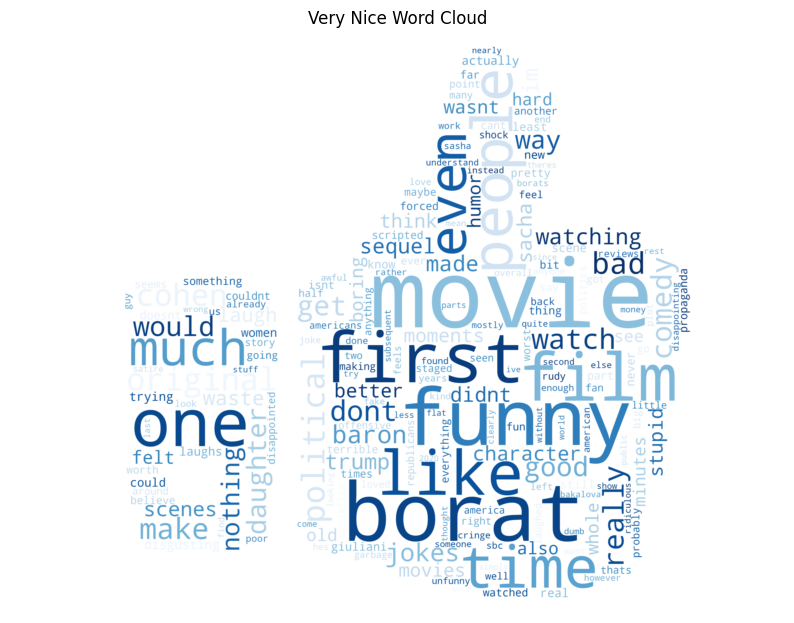

In [151]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_wordcloud(text, mask, max_words, max_font_size, title, color_func):
    word_frequencies = dict(zip(top_positive_words['word'], top_positive_words['frequency']))

    wordcloud = WordCloud(
        background_color="white",
        colormap='Blues',
        max_words=max_words,
        max_font_size=max_font_size,
        mask=mask
    ).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 8))  
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

n = round(df.shape[0] * 0.01)
top_comments_text = ''.join(borat['text_clear'])

# loading custom upvote shape image
upvote_mask = np.array(Image.open('upvote.png'))
)

plot_wordcloud(top_comments_text, upvote_mask, max_words=300, max_font_size=500,
               title=r'Very Nice Word Cloud')


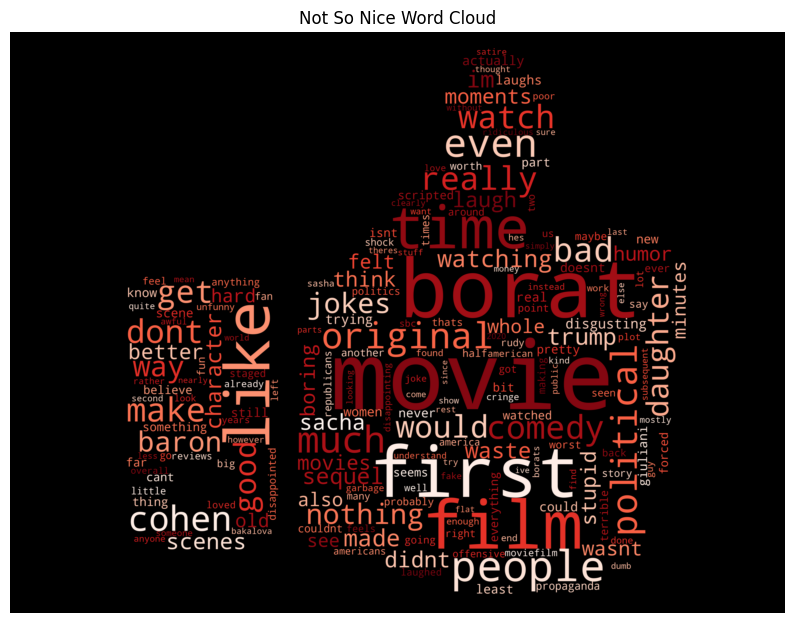

In [156]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_wordcloud(text, mask, max_words, max_font_size, title, color_func):
    word_frequencies = dict(zip(filtered_negative_words['word'], filtered_negative_words['frequency']))

    wordcloud = WordCloud(
        background_color="black",
        colormap = 'Reds',
        max_words=max_words,
        max_font_size=max_font_size,
        mask=mask
    ).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 8)) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


n = round(df.shape[0] * 0.01)
top_comments_text = ''.join(borat['text_clear'])

upvote_mask = np.array(Image.open('upvote.png'))

plot_wordcloud(top_comments_text, upvote_mask, max_words=300, max_font_size=500,
               title=r'Not So Nice Word Cloud')


In [105]:
# displaying 5 random reviews with probabability of negativity 
for _ in range(5):

    source = borat.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['Review'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])

    toxic_proba = model_lr_base.predict_proba(tf_idf_text)

    print('Probability of negativity: ', toxic_proba[:, 0])
    print()


                        brilliant. must watch!!
                    
Probability of negativity:  [0.01919906]


                        this roaringly hilarious (and somewhat disturbing) comedy is exactly what america needs right now. sacha has done it again. i always spend at least 1/4 of the either borat movie just wondering how sacha puts himself through all of that, but he's such a genius that i simply trust the process. the borat subsequent moviefilm can't beat the first borat in terms of shock comedy, but this movie has a more prominent character arc for both borat and his daughter. i'm recommending this to everyone i know... oh yeah, and remember to vote!
                    
Probability of negativity:  [0.34647135]

shockingly grander than the original in some ways, and just plain shocking in general. as should be expected, it doesn't quite have the same shock quality as the first one but it also succeeds by mixing in plenty of new with the effort to recapture the spirit of th

In [178]:
# displaying 5 random reviews with probability of negativity and positivity
for _ in range(5):
    source = borat.sample(n=1)
    text_clear = source['text_clear'].values[0]
    text = source['Review'].values[0]

    print(text)

    tf_idf_text = count_idf.transform([text_clear])
    predicted_proba = model_lr_base.predict_proba(tf_idf_text)
    print('Probability of positivity:', predicted_proba[:, 1])
    print()

unfortunately, i can't rate it less than one star. it's not funny, stupid and disgusting. first borat movie was bad, but this one hit the bottom.
Probability of positivity: [0.0202911]

its to political, not 1% as good as the first part.
Probability of positivity: [0.78700402]


                        sacha boran cohen's resurrection of borat is a timely reminder of the ills of american society that worryingly exist today. it's clever satire and character development makes for a worthwhile watch! although, the comedic formula of the first film doesn't quite reach the same heights in this instalment -it's makes up in being relevant tapping into modern day issues. borat? borate highly.
                    
Probability of positivity: [0.95124003]

i forced myself to watch it to the very end with some hope that the movie would prove me wrong. sadly i was wrong and i feel robbed for wasting my time and endured so much pain and torture with this horror film. the borat sequel film is nothing

In [107]:
#lets get negative reviews proba 
borat_tf_idf = count_idf.transform(borat['text_clear'])
borat_negative_proba = model_lr_base.predict_proba(borat_tf_idf)
borat['negative_proba'] = borat_negative_proba[:, 0]

In [110]:
# lets get positie reviews proba 

borat_tf_idf = count_idf.transform(borat['text_clear'])
borat_positive_proba = model_lr_base.predict_proba(borat_tf_idf)
borat['positive_proba'] = borat_positive_proba[:, 1]

In [117]:
borat

Date                                             Review Rating  \
0      20-Oct-23  \n                        this is the funniest...      5   
1      02-Oct-23  \n                        this movies, has cha...      5   
2      28-Aug-23  \n                        lol, the funniest 01...      5   
3      13-Jul-23  \n                        i find it disgusting...      1   
4      08-Jul-23  \n                        took 3 hours to watc...      5   
...          ...                                                ...    ...   
1996  2020-10-24  i was so worried this film was going to be a d...      5   
1997  2020-10-25  funny movie. some people say not funny like fi...      5   
1998  2020-10-26  it was ok. pushed the edge as always just seem...      3   
1999  2020-11-30  first movie was good and semi honest humor.. t...      2   
2000  2022-01-19  borat movies are a separate art form. somewher...      4   

                                             text_clear  negative_proba  \
0     funniest movie ever see trust ive cackling pas...        0.030712   
1     movies changed way see life ive loved every ca...        0.022188   
2                  lol funniest 01 hour 36 minutes ever        0.428899   
3     find disgusting sophomoric difficult see anyon...        0.422083   
4     took 3 hours watch sort couldnt stop laughing ...        0.317095   
...                                                 ...             ...   
1996  worried film going disappointment genius first...        0.056142   
1997  funny movie people say funny like first one ma...        0.152605   
1998  ok pushed edge always seemed forced think poli...        0.622022   
1999  first movie good semi honest humor one 95 acti...        0.687113   
2000  borat movies separate art form somewhere overd...        0.167343   

      positive_proba  
0           0.969288  
1           0.977812  
2           0.571101  
3           0.577917  
4           0.682905  
...              ...  
1996        0.943858  
1997        0.847395  
1998        0.377978  
1999        0.312887  
2000        0.832657  

[2001 rows x 6 columns]

In [119]:
# create a new column 'Sentiment'
conditions = [
    (borat['positive_proba'] >= 0.6),
    (borat['negative_proba'] >= 0.6),
    ((borat['positive_proba'] < 0.6) & (borat['negative_proba'] < 0.6))
]

choices = ['Positive', 'Negative', 'Neutral']

borat['Sentiment'] = np.select(conditions, choices, default='Neutral')


In [127]:
negative_reviews = borat[borat['Sentiment'] == 'Positive']

# display random 5 rows from the 'Review' column with positive sentiment
random_positive_reviews = negative_reviews.sample(n=5)[['Review', 'Rating']]
random_positive_reviews

Review Rating
1054  borat and his daughter are hilarious. satire f...      5
86    \n                        sometimes you have t...      5
1029  the only low scores will be from upset redneck...      5
1433  borat is back, with this subsequent moviefilm....      4
273   \n                        this is hysterically...      4

In [128]:
negative_reviews = borat[borat['Sentiment'] == 'Negative']

# display random 5 rows from the 'Review' and 'Rating' columns with negative sentiment
random_negative_reviews = negative_reviews.sample(n=5)[['Review', 'Rating']]
random_negative_reviews

Review Rating
719   \n                        a poor second effort...      2
203   \n                        it was ok. definitel...      3
888   it's not funny, humour for people intellectual...      1
1237  the original was a classic but this is a poor ...      1
38    \n                        awful bastardization...      1

In [140]:
# sorting the word_weights dictionary by values (weights)
sorted_word_weights = sorted(word_weights.items(), key=lambda x: x[1])

# get the 100 words with the minimum weights
min_weight_words = sorted_word_weights[:300]

# get the 100 words with the maximum weights
max_weight_words = sorted_word_weights[-300:]

# create DataFrames for words with minimum and maximum weights
min_weight_df = pd.DataFrame(min_weight_words, columns=['words', 'weights'])
max_weight_df = pd.DataFrame(max_weight_words, columns=['words', 'weights'])

# printing the 100 words with the minimum weights
print("100 Words with Minimum Weights:")
print(min_weight_df)

# printing the 100 words with the maximum weights
print("\n100 Words with Maximum Weights:")
print(max_weight_df)


100 Words with Minimum Weights:
        words    weights
0       worst -11.052229
1         bad  -8.640900
2       waste  -8.207912
3       awful  -7.890337
4      boring  -7.013523
..        ...        ...
295       lee  -1.237146
296  attempts  -1.235371
297      want  -1.233175
298       box  -1.231038
299       bin  -1.224909

[300 rows x 2 columns]

100 Words with Maximum Weights:
         words   weights
0       chavez  1.172056
1        spoil  1.174109
2       dramas  1.174954
3         time  1.176221
4         dark  1.176464
..         ...       ...
295    amazing  5.579775
296  wonderful  5.585840
297       best  6.345290
298  excellent  7.207569
299      great  8.185243

[300 rows x 2 columns]


In [137]:
wordcloud_positive = WordCloud(background_color="white",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(max_weight_df.values))

wordcloud_negative = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(min_weight_df.values))

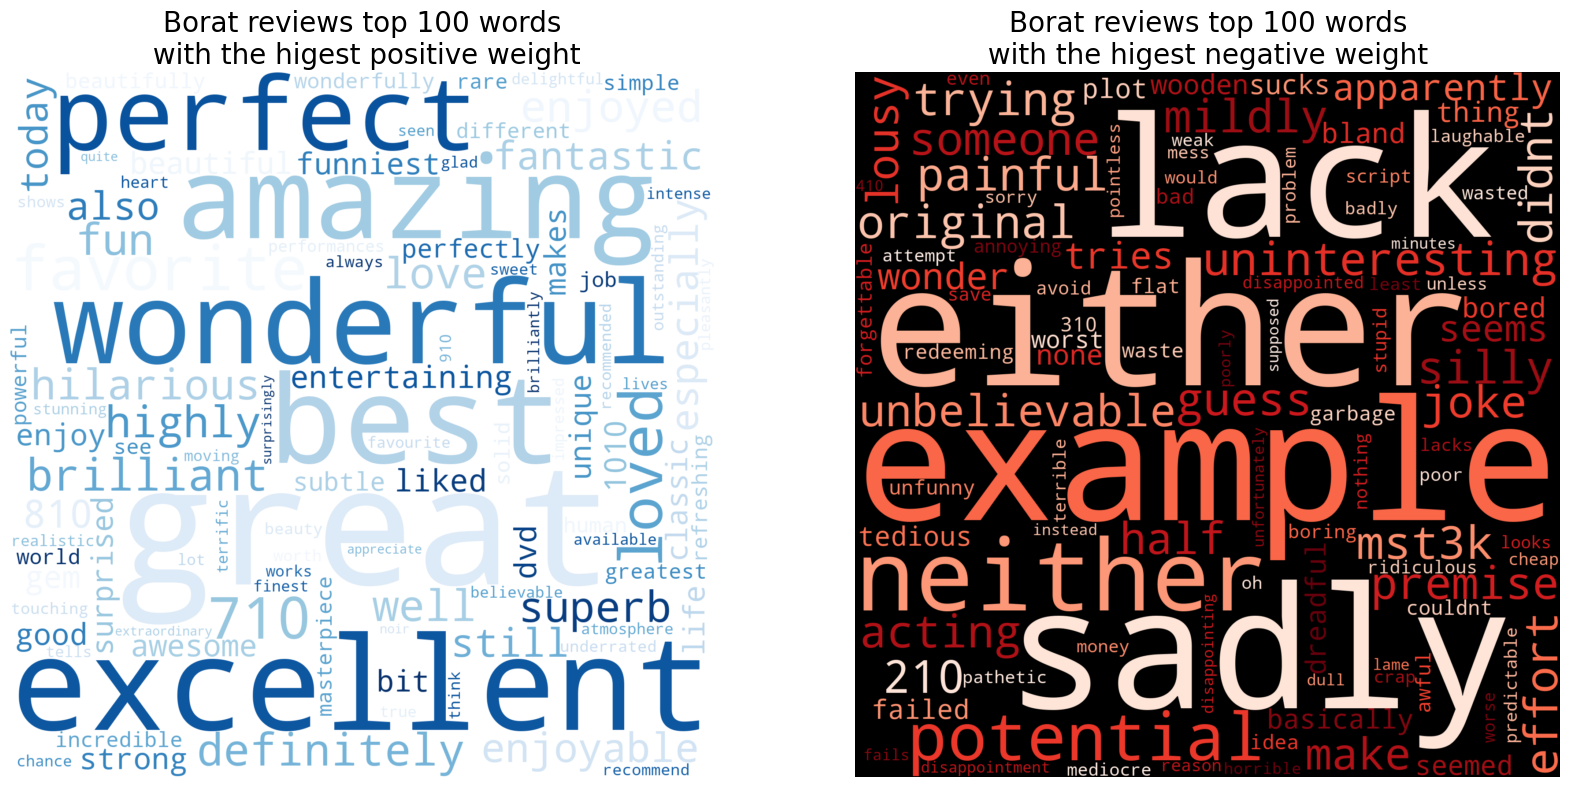

In [139]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Borat reviews top ' +\
                str(weights_max.shape[0]) +\
                ' words\n with the higest positive weight',
               fontsize = 20
               )
ax[1].set_title('Borat reviews top '  +\
                str(weights_min.shape[0]) +\
                ' words\n with the higest negative weight ',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

In [120]:
def generate_trigrams(text):
    tokens = nltk.word_tokenize(text)
    trigrams = [' '.join(tokens[i:i+3]) for i in range(len(tokens)-2)]
    return trigrams

# function to generate trigrams for positive and negative sentiments in the 'borat' DataFrame
def generate_borat_trigrams(dataframe):
    positive_text = dataframe[dataframe['Sentiment'] == 'Positive']['text_clear']
    negative_text = dataframe[dataframe['Sentiment'] == 'Negative']['text_clear']

    positive_text_str = ' '.join(positive_text)
    negative_text_str = ' '.join(negative_text)

    positive_trigrams = generate_trigrams(positive_text_str)
    negative_trigrams = generate_trigrams(negative_text_str)

    positive_trigram_freq = pd.DataFrame(Counter(positive_trigrams).most_common(20), columns=['Positive Trigram', 'Positive Frequency'])
    negative_trigram_freq = pd.DataFrame(Counter(negative_trigrams).most_common(20), columns=['Negative Trigram', 'Negative Frequency'])

    borat_trigrams = pd.concat([negative_trigram_freq, positive_trigram_freq], axis=1)
    borat_trigrams.columns = ['Negative Trigram', 'Negative Frequency', 'Positive Trigram', 'Positive Frequency']

    return borat_trigrams

borat_trigrams = generate_borat_trigrams(borat)
borat_trigrams


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asselkassenova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Negative Trigram  Negative Frequency  \
0            sacha baron cohen                  40   
1              dont waste time                  17   
2            first borat movie                  14   
3   borat subsequent moviefilm                  14   
4             first borat film                   9   
5            sasha baron cohen                   8   
6              loved first one                   7   
7                     da ali g                   6   
8                   ali g show                   6   
9                ive ever seen                   6   
10              like first one                   5   
11          sacha baron cohens                   5   
12              dont get wrong                   5   
13           loved first movie                   4   
14          dont think laughed                   4   
15             funny first one                   4   
16          nothing like first                   4   
17            like first borat                   4   
18             first movie one                   4   
19               big fan first                   4   

              Positive Trigram  Positive Frequency  
0            sacha baron cohen                 111  
1   borat subsequent moviefilm                  63  
2            sasha baron cohen                  22  
3            first borat movie                  21  
4               good first one                  19  
5   glorious nation kazakhstan                  18  
6        make benefit glorious                  17  
7      benefit glorious nation                  17  
8           sacha baron cohens                  16  
9              funny first one                  12  
10            first borat film                  12  
11             first one still                   9  
12        american regime make                   9  
13         regime make benefit                   9  
14             loved first one                   9  
15   delivery prodigious bribe                   8  
16   prodigious bribe american                   8  
17       bribe american regime                   8  
18    borat cultural learnings                   8  
19  cultural learnings america                   8

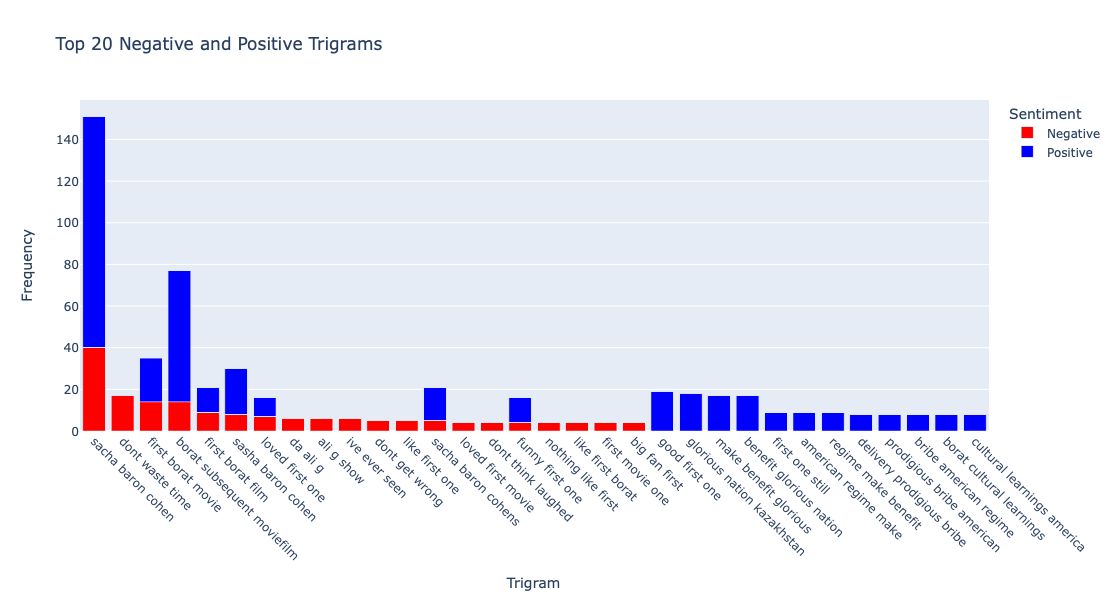

In [171]:
import pandas as pd
import plotly.express as px

# sort the data for both Negative and Positive Trigrams
sorted_negative_data = borat_trigrams.sort_values(by='Negative Frequency', ascending=False).head(20)
sorted_positive_data = borat_trigrams.sort_values(by='Positive Frequency', ascending=False).head(20)

# create DataFrames for Negative and Positive Trigrams
df_negative_trigrams = pd.DataFrame({'Trigram': sorted_negative_data['Negative Trigram'], 'Frequency': sorted_negative_data['Negative Frequency'], 'Sentiment': 'Negative'})
df_positive_trigrams = pd.DataFrame({'Trigram': sorted_positive_data['Positive Trigram'], 'Frequency': sorted_positive_data['Positive Frequency'], 'Sentiment': 'Positive'})

combined_df = pd.concat([df_negative_trigrams, df_positive_trigrams])
fig_combined = px.bar(combined_df, x='Trigram', y='Frequency', color='Sentiment',
                      title='Top 20 Negative and Positive Trigrams',
                      labels={'Trigram': 'Trigram', 'Frequency': 'Frequency', 'Sentiment': 'Sentiment'},
                      color_discrete_map={'Negative': 'red', 'Positive': 'blue'})

fig_combined.update_xaxes(tickangle=45)
fig_combined.update_layout(width=1000, height=600)

fig_combined.show()


In [172]:

def generate_borat_bigrams(dataframe):
    positive_text = dataframe[dataframe['Sentiment'] == 'Positive']['text_clear']
    negative_text = dataframe[dataframe['Sentiment'] == 'Negative']['text_clear']

    positive_text_str = ' '.join(positive_text)
    negative_text_str = ' '.join(negative_text)

    positive_tokens = nltk.word_tokenize(positive_text_str)
    negative_tokens = nltk.word_tokenize(negative_text_str)

    positive_bigrams = [' '.join(bigram) for bigram in ngrams(positive_tokens, 2)]
    negative_bigrams = [' '.join(bigram) for bigram in ngrams(negative_tokens, 2)]

    positive_bigram_freq = pd.DataFrame(Counter(positive_bigrams).most_common(20), columns=['Positive Bigram', 'Positive Frequency'])
    negative_bigram_freq = pd.DataFrame(Counter(negative_bigrams).most_common(20), columns=['Negative Bigram', 'Negative Frequency'])

    borat_bigram = pd.concat([negative_bigram_freq, positive_bigram_freq], axis=1)
    borat_bigram.columns = ['Negative Bigram', 'Negative Frequency', 'Positive Bigram', 'Positive Frequency']

    return borat_bigram

borat_bigram = generate_borat_bigrams(borat)
borat_bigram

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asselkassenova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Negative Bigram  Negative Frequency       Positive Bigram  \
0            baron cohen                  64           baron cohen   
1              first one                  55           sacha baron   
2             waste time                  54             first one   
3            first movie                  49        maria bakalova   
4            first borat                  49  subsequent moviefilm   
5            sacha baron                  45           first borat   
6            borat movie                  33      borat subsequent   
7             first film                  22            first film   
8         original borat                  21           first movie   
9             dont waste                  20               borat 2   
10         funny moments                  20           borat movie   
11  subsequent moviefilm                  18            good first   
12             felt like                  18       borats daughter   
13      borat subsequent                  17            borat film   
14           loved first                  16           funny first   
15            like first                  15                 ali g   
16               borat 2                  15        original borat   
17                 ali g                  14           loved first   
18            borat film                  14           sasha baron   
19           wasnt funny                  14          better first   

    Positive Frequency  
0                  155  
1                  132  
2                  114  
3                   89  
4                   80  
5                   77  
6                   65  
7                   65  
8                   63  
9                   42  
10                  42  
11                  39  
12                  37  
13                  30  
14                  29  
15                  25  
16                  25  
17                  25  
18                  24  
19                  21

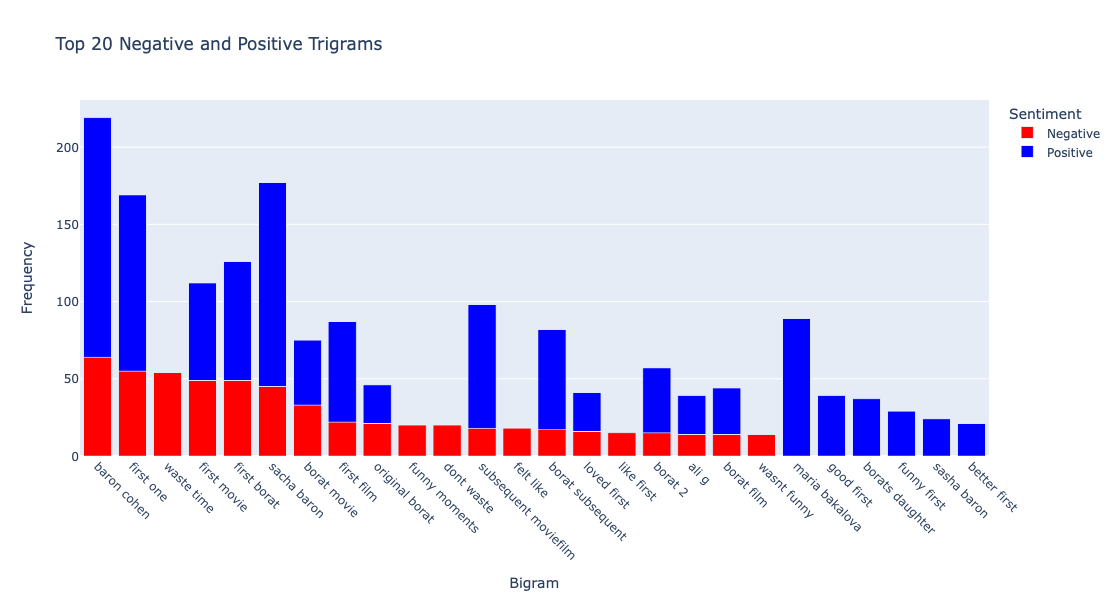

In [175]:

sorted_negative_data = borat_bigram.sort_values(by='Negative Frequency', ascending=False).head(20)
sorted_positive_data = borat_bigram.sort_values(by='Positive Frequency', ascending=False).head(20)

df_negative_bigram = pd.DataFrame({'Bigram': sorted_negative_data['Negative Bigram'], 'Frequency': sorted_negative_data['Negative Frequency'], 'Sentiment': 'Negative'})
df_positive_bigram = pd.DataFrame({'Bigram': sorted_positive_data['Positive Bigram'], 'Frequency': sorted_positive_data['Positive Frequency'], 'Sentiment': 'Positive'})

combined_df = pd.concat([df_negative_bigram, df_positive_bigram])

fig_combined = px.bar(combined_df, x='Bigram', y='Frequency', color='Sentiment',
                      title='Top 20 Negative and Positive Trigrams',
                      labels={'Bigram': 'Bigram', 'Frequency': 'Frequency', 'Sentiment': 'Sentiment'},
                      color_discrete_map={'Negative': 'red', 'Positive': 'blue'})


fig_combined.update_xaxes(tickangle=45)
fig_combined.update_layout(width=1000, height=600)

# display the updated plot with increased size and specific colors for sentiments
fig_combined.show()


In [176]:
borat

Date                                             Review Rating  \
0      20-Oct-23  \n                        this is the funniest...      5   
1      02-Oct-23  \n                        this movies, has cha...      5   
2      28-Aug-23  \n                        lol, the funniest 01...      5   
3      13-Jul-23  \n                        i find it disgusting...      1   
4      08-Jul-23  \n                        took 3 hours to watc...      5   
...          ...                                                ...    ...   
1996  2020-10-24  i was so worried this film was going to be a d...      5   
1997  2020-10-25  funny movie. some people say not funny like fi...      5   
1998  2020-10-26  it was ok. pushed the edge as always just seem...      3   
1999  2020-11-30  first movie was good and semi honest humor.. t...      2   
2000  2022-01-19  borat movies are a separate art form. somewher...      4   

                                             text_clear  negative_proba  \
0     funniest movie ever see trust ive cackling pas...        0.030712   
1     movies changed way see life ive loved every ca...        0.022188   
2                  lol funniest 01 hour 36 minutes ever        0.428899   
3     find disgusting sophomoric difficult see anyon...        0.422083   
4     took 3 hours watch sort couldnt stop laughing ...        0.317095   
...                                                 ...             ...   
1996  worried film going disappointment genius first...        0.056142   
1997  funny movie people say funny like first one ma...        0.152605   
1998  ok pushed edge always seemed forced think poli...        0.622022   
1999  first movie good semi honest humor one 95 acti...        0.687113   
2000  borat movies separate art form somewhere overd...        0.167343   

      positive_proba Sentiment  
0           0.969288  Positive  
1           0.977812  Positive  
2           0.571101   Neutral  
3           0.577917   Neutral  
4           0.682905  Positive  
...              ...       ...  
1996        0.943858  Positive  
1997        0.847395  Positive  
1998        0.377978  Negative  
1999        0.312887  Negative  
2000        0.832657  Positive  

[2001 rows x 7 columns]

In [180]:

sentiment_counts = borat['Sentiment'].value_counts()
total_reviews = sentiment_counts.sum()
proportions = sentiment_counts / total_reviews

# display proportions
print(proportions)


Sentiment
Positive    0.494253
Negative    0.367316
Neutral     0.138431
Name: count, dtype: float64


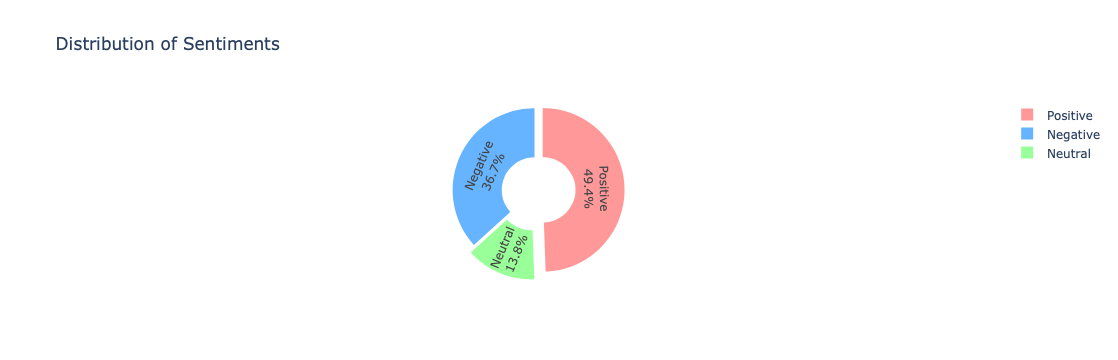

In [196]:
import plotly.express as px

# define custom colors for each sentiment
colors = ['#ff9999', '#66b3ff', '#99ff99']

# pie chart
fig = px.pie(values=proportions, names=proportions.index, 
             title='Distribution of Sentiments',
             color_discrete_sequence=colors,
             hole=0.4)

fig.update_traces(textposition='inside', textinfo='percent+label', pull=[0.1, 0, 0.1])

# show the plot
fig.show()


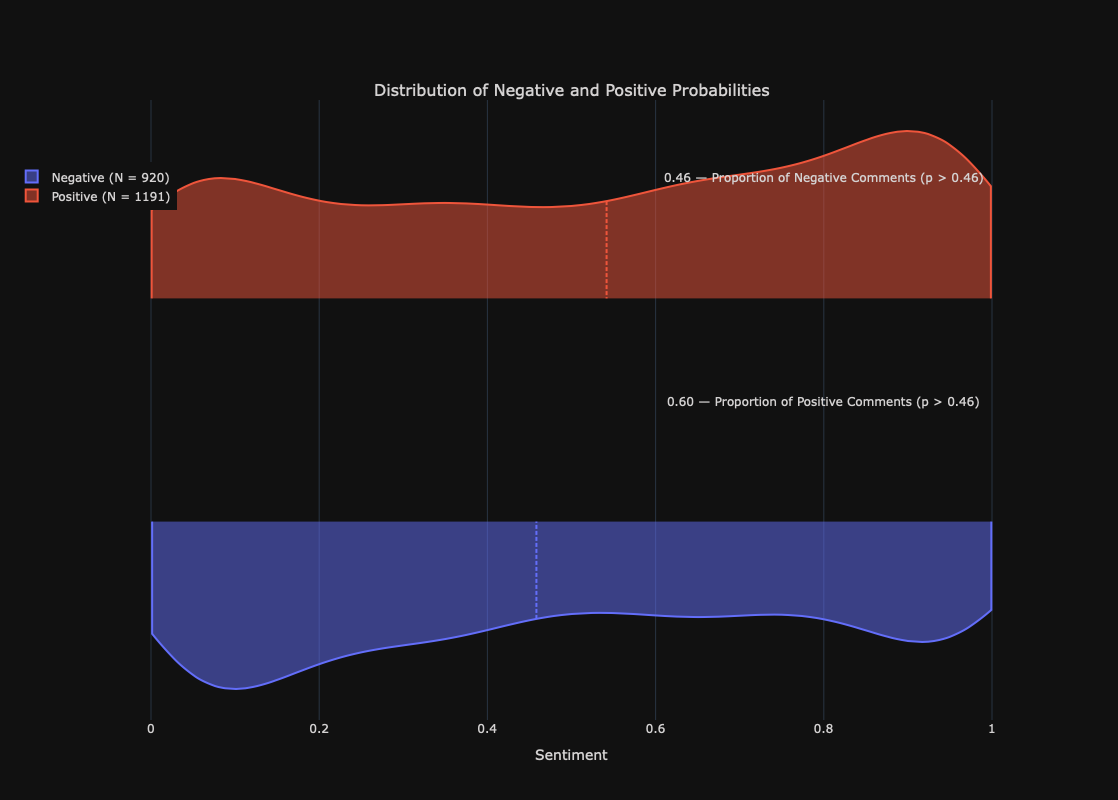

In [184]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate the counts of negative and positive comments above the threshold
borat_negative_count = (borat['negative_proba'] > 0.46).sum()
borat_positive_count = (borat['positive_proba'] > 0.46).sum()

# Create a violin plot with annotations for negative and positive probabilities
fig = make_subplots(1, 1, subplot_titles=['Distribution of Negative and Positive Probabilities'])

fig.add_trace(go.Violin(
    x=borat['negative_proba'],
    meanline_visible=True,
    name='Negative (N = %i)' % borat_negative_count,  # Update with negative count
    side='negative',
    spanmode='hard'
))

fig.add_trace(go.Violin(
    x=borat['positive_proba'],
    meanline_visible=True,
    name='Positive (N = %i)' % borat_positive_count,  # Update with positive count
    side='positive',
    spanmode='hard'
))

fig.add_annotation(x=0.8, y=1.5,
                   text="%0.2f — Proportion of Negative Comments (p > 0.46)" % borat_share_neg,
                   showarrow=False,
                   yshift=10)

fig.add_annotation(x=0.8, y=0.5,
                   text="%0.2f — Proportion of Positive Comments (p > 0.46)" % borat_share_pos,
                   showarrow=False,
                   yshift=10)

fig.update_traces(orientation='h',
                  width=1.5,
                  points=False
                  )

fig.update_layout(height=800,  # Increase height
                  width=1200,  # Increase width
                  xaxis_zeroline=False,
                  template='plotly_dark',
                  font_color='rgba(212, 210, 210, 1)',
                  legend=dict(
                      y=0.9,
                      x=-0.1,
                      yanchor='top',
                  ),
                  yaxis=dict(title='Sentiment Probability'),
                  xaxis=dict(title='Sentiment'),
                  violinmode='overlay'  # Overlaying violins for better comparison
                  )

fig.update_yaxes(visible=False)

fig.show()
